In [1]:
import cv2
import seaborn as sns

from tests.speedtest import generate_heatmap, generate_plots, run_test
from utils import get_files_from_array

/home/bcowan/.local/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
dirs = ['bark', 'bikes', 'boat', 'graf', 'leuven', 'trees', 'ubc', 'wall']

cv2.ocl.setUseOpenCL(False)

files = get_files_from_array(dirs)
images = [cv2.imread(image, 0) for image in files]
data = run_test(images, True)

Running test 1/144 - Agast/AKAZE
Invalid combination - Agast/AKAZE
Running test 2/144 - Agast/BRISK
Running test 3/144 - Agast/KAZE
Invalid combination - Agast/KAZE
Running test 4/144 - Agast/ORB
Running test 5/144 - Agast/Boost
Running test 6/144 - Agast/BRIEF
Running test 7/144 - Agast/DAISY
Running test 8/144 - Agast/FREAK
Running test 9/144 - Agast/LATCH
Running test 10/144 - Agast/LUCID
Running test 11/144 - Agast/SIFT
Running test 12/144 - Agast/SURF
Running test 13/144 - AKAZE/AKAZE
Running test 14/144 - AKAZE/BRISK
Running test 15/144 - AKAZE/KAZE
Running test 16/144 - AKAZE/ORB
Running test 17/144 - AKAZE/Boost
Running test 18/144 - AKAZE/BRIEF
Running test 19/144 - AKAZE/DAISY
Running test 20/144 - AKAZE/FREAK
Running test 21/144 - AKAZE/LATCH
Running test 22/144 - AKAZE/LUCID
Running test 23/144 - AKAZE/SIFT
Running test 24/144 - AKAZE/SURF
Running test 25/144 - BRISK/AKAZE
Invalid combination - BRISK/AKAZE
Running test 26/144 - BRISK/BRISK
Running test 27/144 - BRISK/KAZE
I

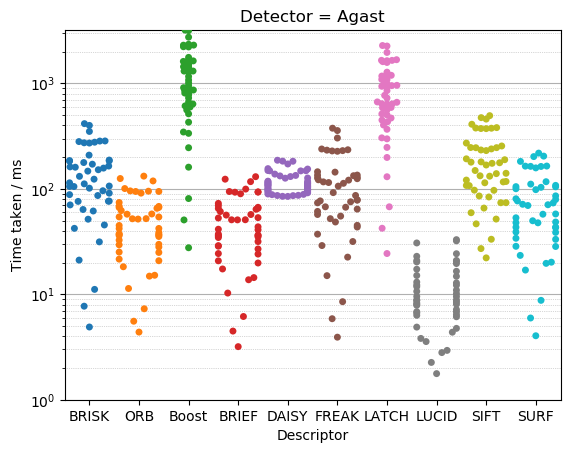

In [3]:
sns.reset_orig()
generate_plots(data)

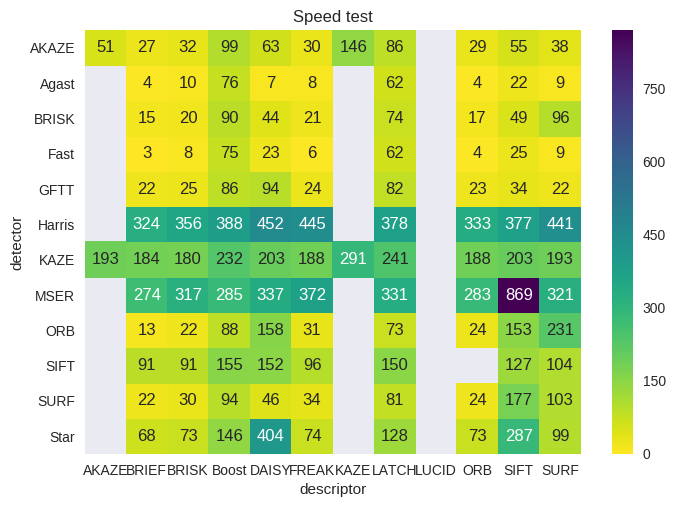

In [4]:
sns.set()
display(generate_heatmap(data))